In [2]:
import h5py
import random
import numpy as np
import tensorflow as tf
from datetime import datetime
import H5pyHelper
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import dask.array as da
#from dask.array.slicing import shuffle_slice
import cv2
import pandas as pd
import os
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
BATCH_SIZE = 32


Num GPUs Available:  1


In [4]:
df = pd.read_csv("clean_data/image_paths.csv")

## get all unique labels and sort them (for classification_report)
inps = list(df['label'].unique())
inps.sort()
print(inps)

# shuffle dataframe
df = df.sample(frac=1)


# stratify ensures that train validate and test sets have approximately the same percentage of samples of each target class as the complete set
# more info here: https://stats.stackexchange.com/questions/250273/benefits-of-stratified-vs-random-sampling-for-generating-training-data-in-classi
# this is good because we have some data that is not evenly represented in the dataset which leads to poor performance if not evenly distributed in training/validating/testing
train,test = train_test_split(df, test_size=0.1, random_state=1,stratify=df['label'])
train,validate = train_test_split(train, test_size=0.111, random_state=1,stratify=train['label']) # 0.25 x 0.8 = 0.2

image_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    horizontal_flip=True,
    rescale= 1.0/255.0,
    rotation_range=30
    )

test_image_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rescale= 1.0/255.0,
    )

train_iterator = image_datagen.flow_from_dataframe(train,x_col="image-path",y_col="label",batch_size=BATCH_SIZE,target_size=(256,256),classes=inps,class_mode="categorical", shuffle=True)

batch_x,batch_y = train_iterator.next()
NUM_CLASSES = batch_y.shape[1]

validate_iterator = image_datagen.flow_from_dataframe(validate,x_col="image-path",y_col="label",batch_size=BATCH_SIZE, target_size=(256,256),classes=inps,class_mode="categorical", shuffle=True)

test_iterator = test_image_datagen.flow_from_dataframe(test,x_col="image-path",y_col="label",batch_size=BATCH_SIZE, target_size=(256,256),classes=inps,class_mode="categorical")

['Abronia elliptica', 'Abronia fragrans', 'Abronia nana', 'Achillea millefolium', 'Aconitum columbianum', 'Actaea rubra', 'Agastache urticifolia', 'Agoseris aurantiaca', 'Agoseris glauca', 'Aliciella pinnatifida', 'Alisma triviale', 'Allionia incarnata', 'Allium acuminatum', 'Allium cernuum', 'Allium geyeri', 'Allium macropetalum', 'Allium schoenoprasum', 'Alyssum simplex', 'Amauriopsis dissecta', 'Amelanchier utahensis', 'Anagallis arvensis', 'Anaphalis margaritacea', 'Androsace septentrionalis', 'Androstephium breviflorum', 'Anemone multifida', 'Anemone narcissiflora', 'Anemone patens', 'Anemopsis californica', 'Antennaria anaphaloides', 'Antennaria dimorpha', 'Antennaria media', 'Antennaria parvifolia', 'Antennaria rosea', 'Antennaria umbrinella', 'Anthemis cotula', 'Anticlea elegans', 'Apocynum androsaemifolium', 'Apocynum cannabinum', 'Aquilegia caerulea', 'Aquilegia chrysantha', 'Aquilegia elegantula', 'Arctium minus', 'Arctostaphylos patula', 'Arenaria lanuginosa', 'Argemone pol

In [5]:
## modified code from https://towardsdatascience.com/3-things-you-need-to-know-before-you-train-test-split-869dfabb7e50
def get_class_counts(df):
    grp = df.groupby(['label']).nunique()

    return grp.to_dict()['image-path']
def get_class_proportions(df):
    class_counts = get_class_counts(df)
    return {val[0]: round(val[1]/df.shape[0],4) for val in class_counts.items()}

print(get_class_counts(test)['Astragalus lentiginosus'])
#print(get_class_proportions(df))
#print (get_class_proportions(train))
#print (get_class_proportions(validate))
#print (get_class_proportions(test))

20


In [6]:
## alex net
model = models.Sequential([
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same", kernel_regularizer=tf.keras.regularizers.l2(l=0.02)),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Flatten(),
    #layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.7),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 384)       8

In [7]:
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.0001), metrics=['accuracy'])

In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
fit = model.fit(x=train_iterator,
                steps_per_epoch= len(train_iterator),
                #callbacks=[callback], 
                validation_steps= len(validate_iterator),
                validation_data=validate_iterator,
                verbose=1,
                epochs=500)

Epoch 1/500
357/357 [==============================] - 111s 304ms/step - loss: 14.1269 - accuracy: 0.0145 - val_loss: 12.3291 - val_accuracy: 0.0211
Epoch 2/500
357/357 [==============================] - 108s 302ms/step - loss: 13.5025 - accuracy: 0.0195 - val_loss: 12.2065 - val_accuracy: 0.0246
Epoch 3/500
357/357 [==============================] - 107s 299ms/step - loss: 13.1183 - accuracy: 0.0222 - val_loss: 11.9974 - val_accuracy: 0.0302
Epoch 4/500
357/357 [==============================] - 107s 301ms/step - loss: 12.7740 - accuracy: 0.0255 - val_loss: 11.8347 - val_accuracy: 0.0582
Epoch 5/500
357/357 [==============================] - 111s 311ms/step - loss: 12.5436 - accuracy: 0.0302 - val_loss: 11.7100 - val_accuracy: 0.0540
Epoch 6/500
357/357 [==============================] - 107s 299ms/step - loss: 12.3292 - accuracy: 0.0342 - val_loss: 11.6575 - val_accuracy: 0.0646
Epoch 7/500
357/357 [==============================] - 107s 301ms/step - loss: 12.1860 - accuracy: 0.0368 

In [ ]:
# get all test labels from dataframe
y_true = []

# get all true labels
for i in range(len(test_iterator)):
    batch_x,batch_y = test_iterator.next()
    batch_y = list(batch_y)
    y_true += batch_y

#print(y_true)
# get test predictions
y_pred = model.predict(x = test_iterator,
                    steps = len(test_iterator),
                    batch_size=BATCH_SIZE,
                    verbose=1)

# convert one hot to max index
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_true, axis=1)

print(accuracy_score(y_true,y_pred) * 100, "%")

# have to include labels parameter because test set does not have all of the classes from inps
matrix = classification_report(y_true,y_pred,labels=np.arange(len(inps)),target_names =inps)
print('Classification report: \n',matrix)




NameError: name 'test_iterator' is not defined

In [ ]:
model.save('model/')

INFO:tensorflow:Assets written to: model/assets


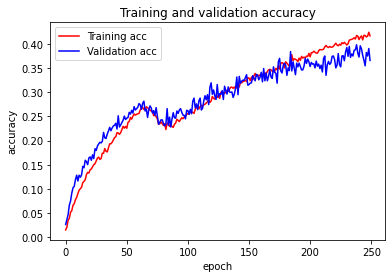

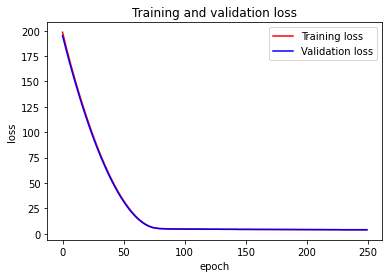

In [ ]:
import matplotlib.pyplot as plt 
#Graphing our training and validation
acc = fit.history['accuracy']
val_acc = fit.history['val_accuracy']
loss = fit.history['loss']
val_loss = fit.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

Normalized confusion matrix


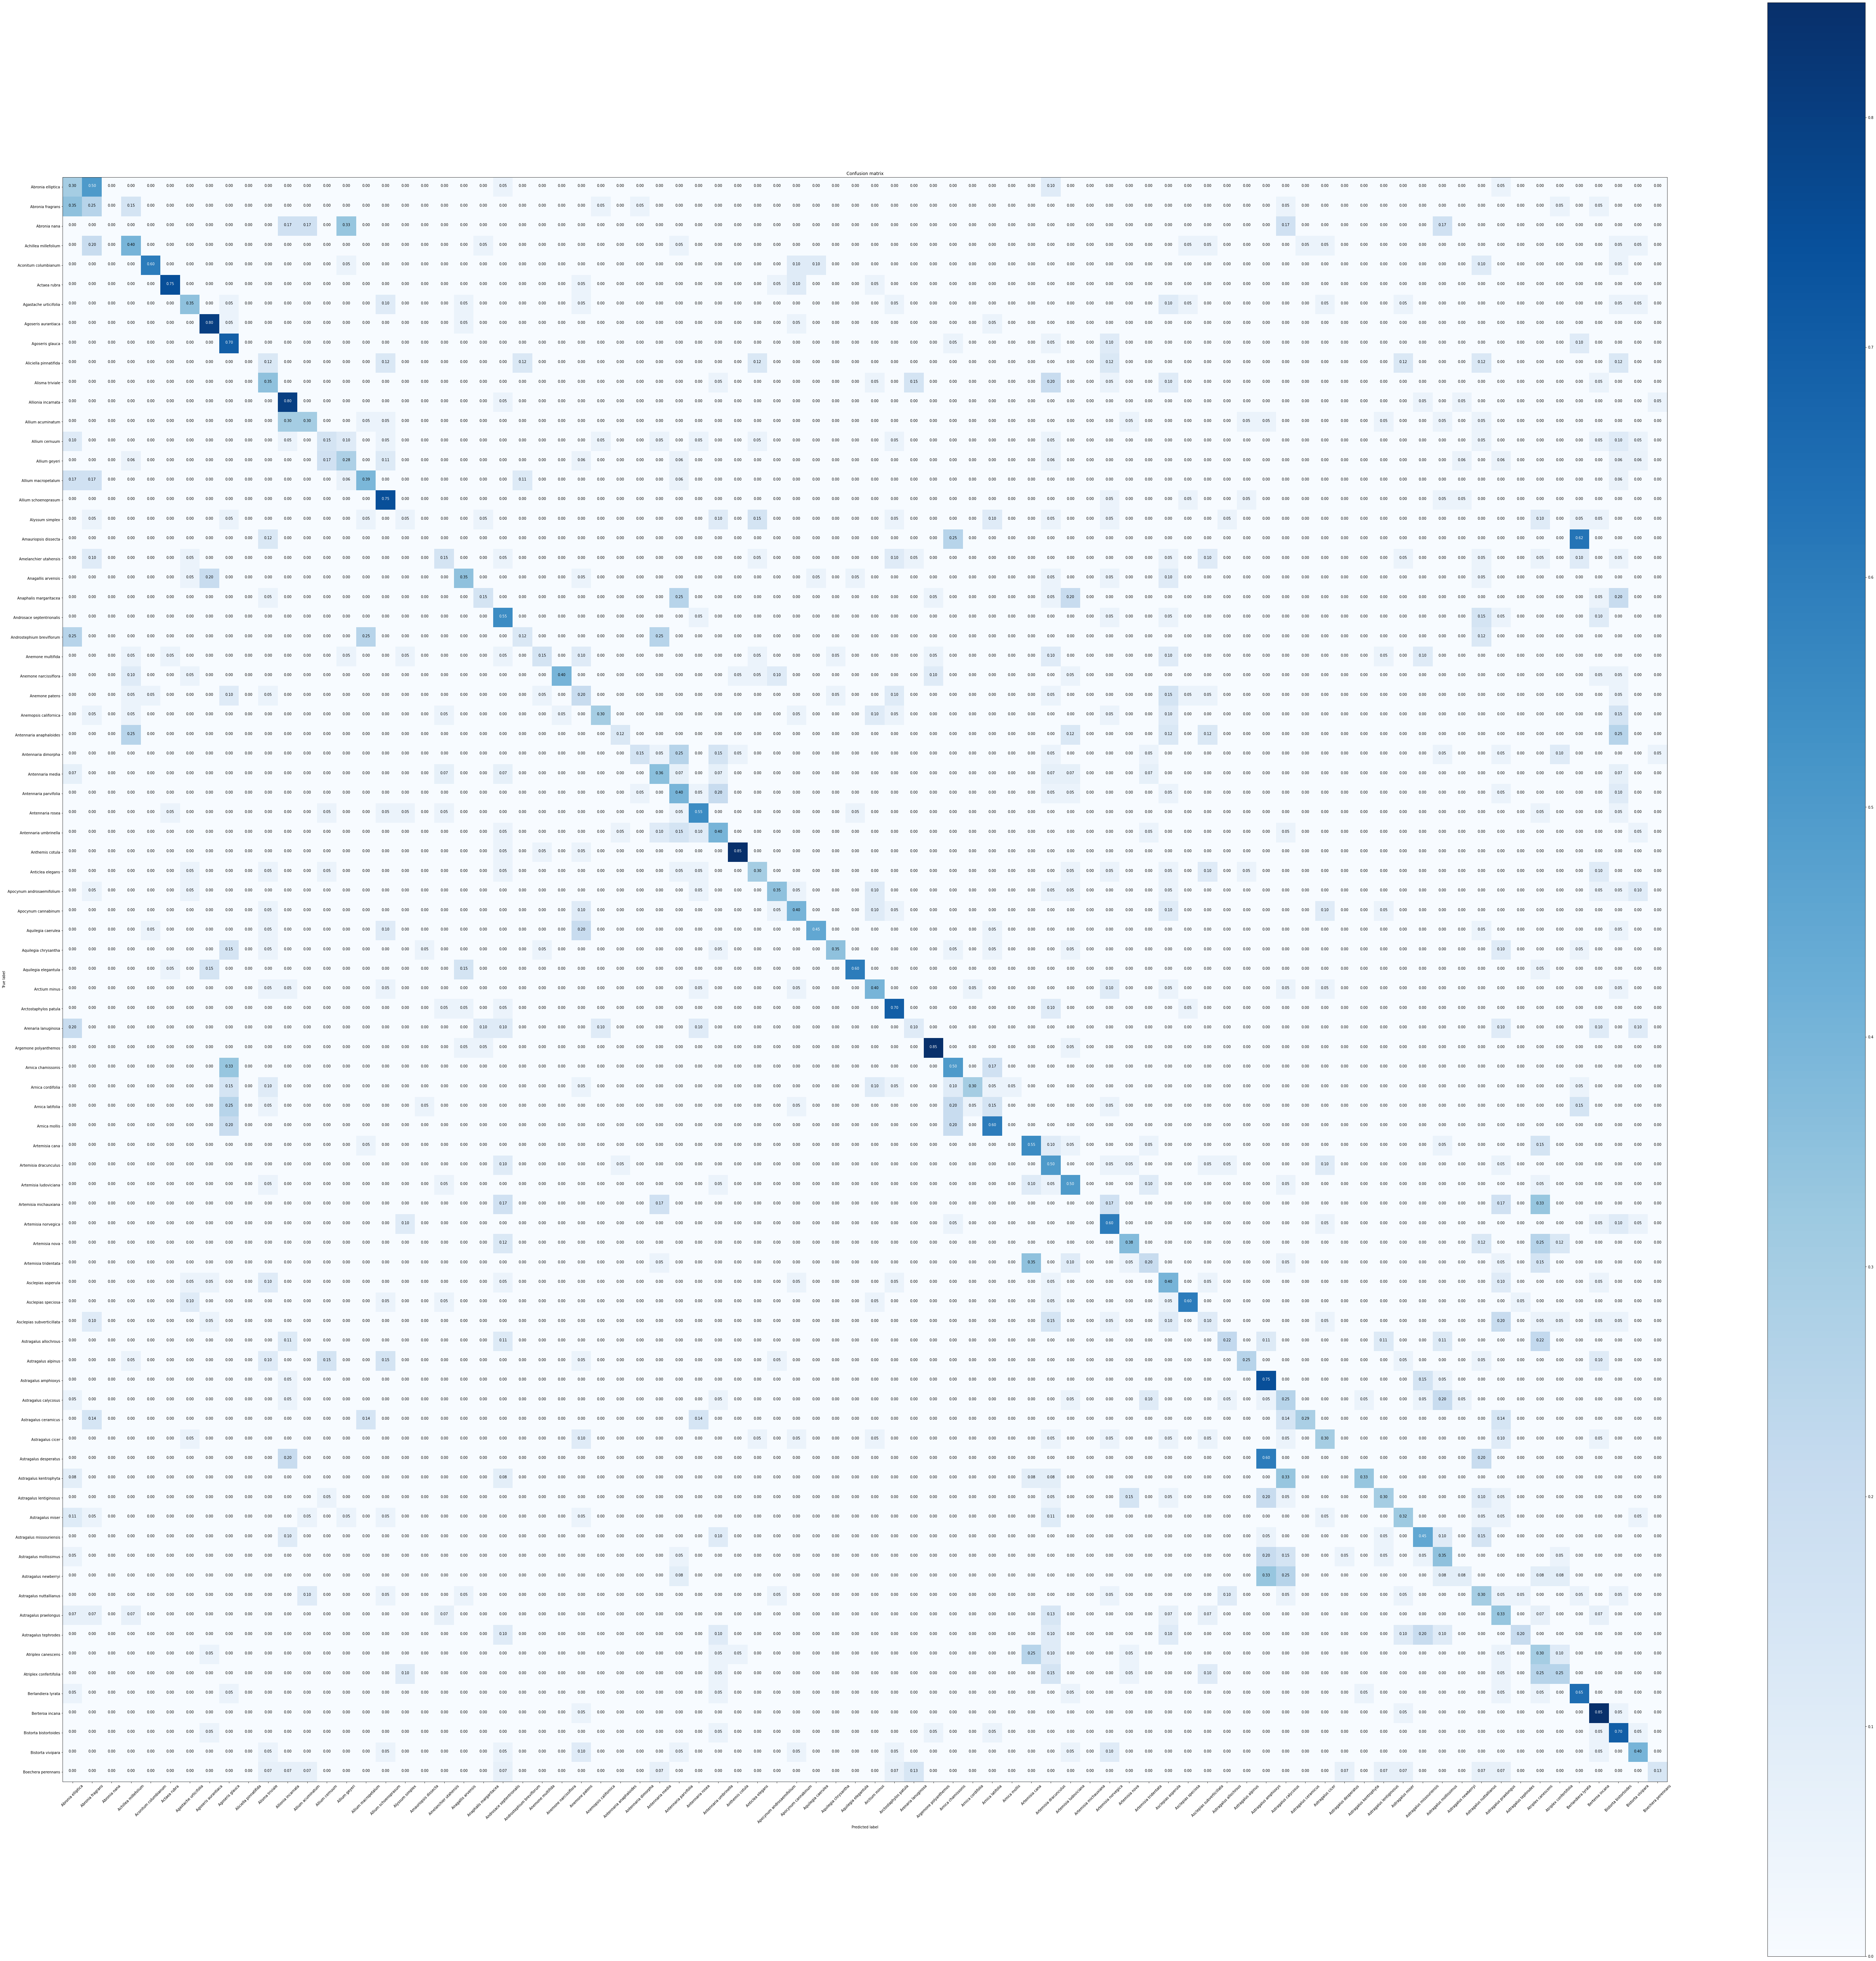

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

# grabbed from here: https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa
confusion_matrix = confusion_matrix(y_true,y_pred)

def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
 
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
 
    # print(cm)
 
    plt.figure(figsize=(100,100))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
       plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

plot_confusion_matrix(confusion_matrix,inps,normalize=True)